In [1]:
%matplotlib inline
# important for correctly savefig
import os,glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
aa=np.asarray
from VUE.py_model.DiModel import *
from VUE.py_model.Aux_DiModel import *
from VUE.py_model.MarkovFit import markov_fit
import h5py

import pyperplot as ppp
from matplotlib.ticker import FormatStrFormatter

elinewidth=0.5
capsize=1.5

In [2]:
figs_folder='figs/sim'
mk=ppp.Marker('fig.yml')

In [3]:
res_folder="res"
subj="sall"
grdata_save={"subject":subj}
save_file_path=f"./connect/data/{subj}.npy"

h5file=h5py.File(f"VUE/res/{subj}/bps.jld","r")
k,R,_,nondt,frus=h5file['best_params'][()]

In [4]:
delta_t=0.02 # fixed
sigma=1 # fixed
var=sigma**2
mapping_range=3 # sigma range

num_states=351 # 

stop_val=10. # end of thr time
stop_cutoff=0. # no cutoff


tbar=np.floor(stop_val/delta_t)
t_vec=np.arange(delta_t,tbar*delta_t+1e-10,delta_t)

a=R*np.ones_like(t_vec) # reward
ana=a.copy()    # reward for another direction
c=1.

rho=0

# times
tw1=1 # time to wait / time step
tw2=1 # time to wait / time step
tu=0 # time to second stage / time step

# Coherence and probability of stage1
zs=aa([-0.26,-0.16,-0.12,-0.10,-0.08,-0.06,-0.04,-0.02,0,0.02,0.04,0.06,0.08,0.10,0.12,0.16,0.26])
ps=aa([1.,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1])
ps/=ps.sum()
mid_z=int(np.floor(len(zs)//2))

# Coherence and probability of stage2
zs2=aa([-0.26,0.26])
ps2=aa([0.5,0.5])
EV22=-1
mid_z2=int(np.floor(len(zs2)//2))

# median filter parameters
runmed_width=7
runmed_width_inner=7

@jit
def func(x):
    return big_Z_bound(k,zs,ps,var,x,stop_val,mid_z)
@jit
def func2(x):
    return big_Z_bound(k,zs,ps,var,x,stop_val,mid_z2)

xbar=5.;xbar2=5.


# Regeneration of the data according to fitted parameters 

## Uuncertainty Response Condition

In [5]:
def synthesis(k,a,c,rho,frus,tw1,tw2,zs,ps,zs2,ps2,sigma,xbar,xbar2,num_states,delta_t,stop_val,ana,mapping_range=3):
    EV22=-np.inf
    V02,V2,D2,EVnext2,Rh_left2,Rh_right2,EV2c2,prob_left2,rho2_=\
        d_prob(k,a,c,rho,tw2,tu,EV22,zs2,ps2,sigma,num_states,delta_t,xbar2,stop_val,ana,mapping_range)
    
    V0,V,D,EVnext,Rh_left,Rh_right,EV2c,prob_left,rho_=\
        d_prob(k,a,c,rho,tw1,tu,V02-frus,zs,ps,sigma,num_states,delta_t,xbar,stop_val,ana,mapping_range)
    return V0,V,D,EVnext,Rh_left,Rh_right,EV2c,prob_left,rho_,V02,V2,D2,EVnext2,Rh_left2,Rh_right2,EV2c2,prob_left2,rho2_

In [6]:
V0,V,D,EVnext,Rh_left,Rh_right,EV2c,prob_left,rho_,V02,V2,D2,EVnext2,Rh_left2,Rh_right2,EV2c2,prob_left2,rho2_=\
    synthesis(k,a,c,rho,frus,tw1,tw2,zs,ps,zs2,ps2,sigma,xbar,xbar2,num_states,delta_t,stop_val,ana,mapping_range=3)

In [7]:
idx_end=int((stop_val-stop_cutoff)/delta_t)

V=V[:,:idx_end]
D=D[:,:idx_end]
EVnext=EVnext[:,:idx_end]
Rh_left=Rh_left[:,:idx_end]
Rh_right=Rh_right[:,:idx_end]
prob_left=prob_left[:,:idx_end]

V2=V2[:,:idx_end]
D2=D2[:,:idx_end]
EVnext2=EVnext2[:,:idx_end]
Rh_left2=Rh_left2[:,:idx_end]
Rh_right2=Rh_right2[:,:idx_end]
prob_left2=prob_left2[:,:idx_end]

## Standard Condition

In [8]:
EV2_std=-np.inf
V0_std,V_std,D_std,EVnext_std,Rh_left_std,Rh_right_std,EV2c_std,prob_left_std,rho_std=d_prob(
    k,a,c,rho,tw1,tu,EV2_std,zs,ps,sigma,num_states,delta_t,xbar,stop_val,ana,mapping_range)

In [9]:
V_std=V_std[:,:idx_end]
D_std=D_std[:,:idx_end]
EVnext_std=EVnext_std[:,:idx_end]
Rh_left_std=Rh_left_std[:,:idx_end]
Rh_right_std=Rh_right_std[:,:idx_end]
prob_left_std=prob_left_std[:,:idx_end]

In [10]:
def transfer_bounds_to_rt(k,zs,ps,sigma,a_upper,a_lower,a_inner_upper,a_inner_lower,delta_t,xbar,num_states,stop_val,runmed_width,runmed_width_inner):
    g_inners=[]
    g_uppers=[]
    g_lowers=[]
    gg_inners=[] # general inners
    gg_uppers=[] # general uppers
    gg_lowers=[] # general lowers
    z_side=zs # both side
    for i,z in enumerate(z_side):
        g_upper,g_lower,g_inner,t_vec,ret_num_tr_states=markov_fit(
            ou_drift=k*z,ou_leak=0.,ou_var=sigma**2,ou_init=0.,
            a_upper=a_upper,a_lower=a_lower,
            a_inner_upper=a_inner_upper,a_inner_lower=a_inner_lower,
            delta_t=delta_t,
            covered_range=aa([-xbar,xbar]),num_tr_states=num_states,stop_val=stop_val,runmed_width=runmed_width,runmed_width_inner=runmed_width_inner)
        if i==0:
            gs_upper=ps[i]*g_upper
            gs_lower=ps[i]*g_lower
            gs_inner=ps[i]*g_inner
        else:
            gs_upper+=ps[i]*g_upper
            gs_lower+=ps[i]*g_lower
            gs_inner+=ps[i]*g_inner
        g_uppers.append(g_upper) 
        g_lowers.append(g_lower)
        g_inners.append(g_inner)
        gg_uppers.append(g_upper/g_upper.sum())
        gg_lowers.append(g_lower/g_lower.sum())
        gg_inners.append(g_inner/g_inner.sum())

    return tuple([aa(tmp) for tmp in [g_uppers,g_lowers,g_inners,\
        gs_upper,gs_lower,gs_inner,\
        gg_uppers,gg_lowers,gg_inners]]+[t_vec])

In [11]:
def gen_dist(k,zs,ps,sigma,
    a_upper,a_lower,a_inner_upper,a_inner_lower,
    a_upper2,a_lower2,a_inner_upper2,a_inner_lower2,
    a_upper_std,a_lower_std,a_inner_upper_std,a_inner_lower_std,
    delta_t,xbar,num_states,stop_val,runmed_width,runmed_width_inner):
    
    g_uppers,g_lowers,g_inners,gs_upper,gs_lower,gs_inner,gg_uppers,gg_lowers,gg_inners,t_vec=\
        transfer_bounds_to_rt(k,zs,ps,sigma,a_upper,a_lower,a_inner_upper,a_inner_lower,delta_t,xbar,num_states,stop_val,runmed_width,runmed_width_inner)
    
    g_uppers2,g_lowers2,g_inners2,gs_upper2,gs_lower2,gs_inner2,gg_uppers2,gg_lowers2,gg_inners2,_=\
        transfer_bounds_to_rt(k,zs2,ps2,sigma,a_upper2,a_lower2,a_inner_upper2,a_inner_lower2,delta_t,xbar,num_states,stop_val,runmed_width,runmed_width_inner)

    g_uppers_std,g_lowers_std,g_inners_std,gs_upper_std,gs_lower_std,gs_inner_std,gg_uppers_std,gg_lowers_std,gg_inners_std,_=\
        transfer_bounds_to_rt(k,zs,ps,sigma,a_upper_std,a_lower_std,a_inner_upper_std,a_inner_lower_std,delta_t,xbar,num_states,stop_val,runmed_width,runmed_width_inner)
    
    return g_uppers,g_lowers,g_inners,gs_upper,gs_lower,gs_inner,gg_uppers,gg_lowers,gg_inners,\
    g_uppers2,g_lowers2,g_inners2,gs_upper2,gs_lower2,gs_inner2,gg_uppers2,gg_lowers2,gg_inners2,\
    g_uppers_std,g_lowers_std,g_inners_std,gs_upper_std,gs_lower_std,gs_inner_std,gg_uppers_std,gg_lowers_std,gg_inners_std,t_vec

In [12]:
a_upper,a_lower,a_inner_upper,a_inner_lower=transfer_D_to_bounds(D)
a_upper2,a_lower2,a_inner_upper2,a_inner_lower2=transfer_D_to_bounds(D2)
a_upper_std,a_lower_std,a_inner_upper_std,a_inner_lower_std=transfer_D_to_bounds(D_std)

In [13]:
g_uppers,g_lowers,g_inners,gs_upper,gs_lower,gs_inner,gg_uppers,gg_lowers,gg_inners,\
    g_uppers2,g_lowers2,g_inners2,gs_upper2,gs_lower2,gs_inner2,gg_uppers2,gg_lowers2,gg_inners2,\
    g_uppers_std,g_lowers_std,g_inners_std,gs_upper_std,gs_lower_std,gs_inner_std,gg_uppers_std,gg_lowers_std,gg_inners_std,t_vec=gen_dist(k,zs,ps,sigma,
    a_upper,a_lower,a_inner_upper,a_inner_lower,
    a_upper2,a_lower2,a_inner_upper2,a_inner_lower2,
    a_upper_std,a_lower_std,a_inner_upper_std,a_inner_lower_std,
    delta_t,xbar,num_states,stop_val-stop_cutoff,runmed_width,runmed_width_inner)

/tmp/ipykernel_468999/1256352139.py:29: RuntimeWarning: invalid value encountered in true_divide
  gg_inners.append(g_inner/g_inner.sum())


In [14]:
t_vec_end=t_vec[:idx_end]
prob_upper=np.apply_along_axis(lambda x:np.sum(x)*delta_t,1,g_uppers)
prob_lower=np.apply_along_axis(lambda x:np.sum(x)*delta_t,1,g_lowers)
prob_inner=np.apply_along_axis(lambda x:np.sum(x)*delta_t,1,g_inners)
up_prop=prob_inner/(prob_upper+prob_inner+prob_lower)

## Figure 4A

figure used in paper is stored in paper_figs/fig4/A.svg


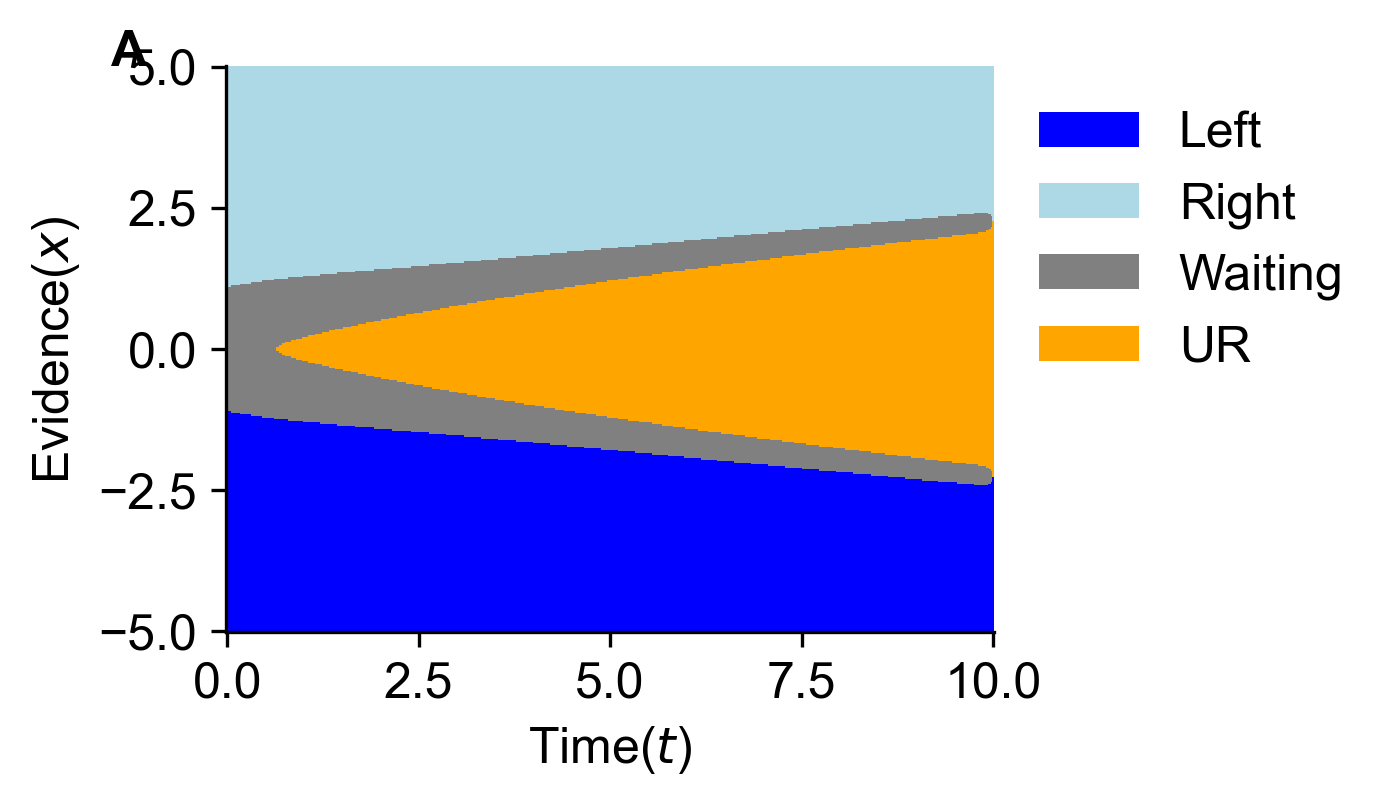

In [15]:
colors = ["blue","lightblue","grey","orange"]
cmap = mpl.colors.ListedColormap(colors,"", len(colors))
Dcf_kwargs={'cmap':cmap,'rasterized':True}
Daxes_kwargs={'xlabel':'Time($t$)','ylabel':'Evidence($x$)'}
def get_xxyy(xr,yr,D):
    return np.linspace(xr[0],xr[1],D.shape[1]),np.linspace(yr[0],yr[1],D.shape[0])
xxyy=get_xxyy([0,stop_val-stop_cutoff],[-xbar,xbar],D)

with ppp.SF('D_UR',figs_folder,mk) as (fig,axes):
    cf=axes.pcolormesh(*xxyy,D,**Dcf_kwargs)
    proxy=[plt.Rectangle((0,0),1,1,fc = pc) 
        for i,pc in enumerate(cf.cmap.colors)]
    axes.legend(proxy, ['Left', 'Right','Waiting','UR'],bbox_to_anchor=(1,1))
    axes.set(**Daxes_kwargs)

## Figure 4C

figure used in paper is stored in paper_figs/fig4/C.svg


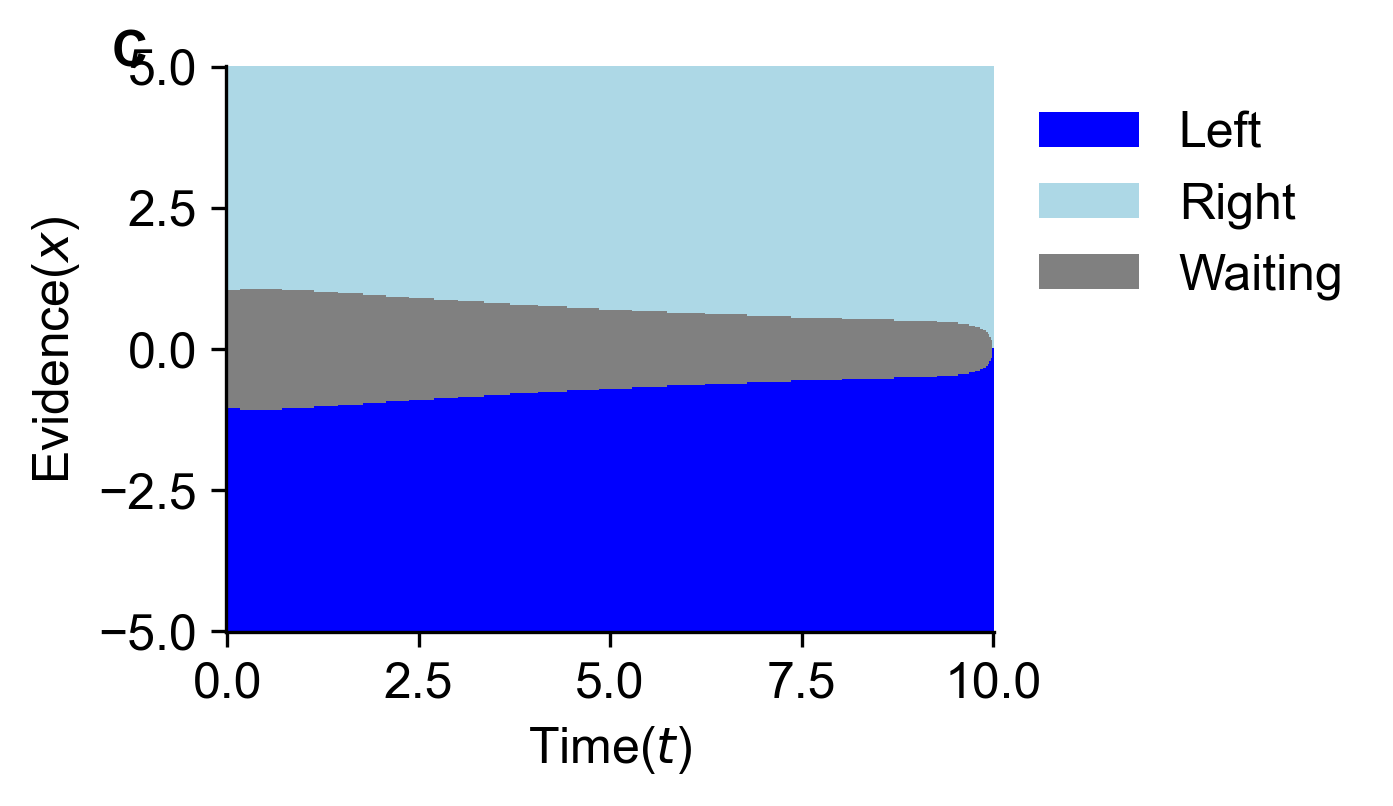

In [16]:
colors = ["blue","lightblue","grey"]
cmap = mpl.colors.ListedColormap(colors,"", len(colors))
Dcf_kwargs2={'cmap':cmap,'rasterized':True}

with ppp.SF('D_STD',figs_folder,mk) as (fig,axes):
    cf=axes.pcolormesh(*xxyy,D_std,**Dcf_kwargs2)
    proxy=[plt.Rectangle((0,0),1,1,fc = pc) 
        for i,pc in enumerate(cf.cmap.colors)]
    axes.legend(proxy, ['Left', 'Right', 'Waiting'],bbox_to_anchor=(1,1))
    axes.set(**Daxes_kwargs)

## Figure 4B

figure used in paper is stored in paper_figs/fig4/B.svg


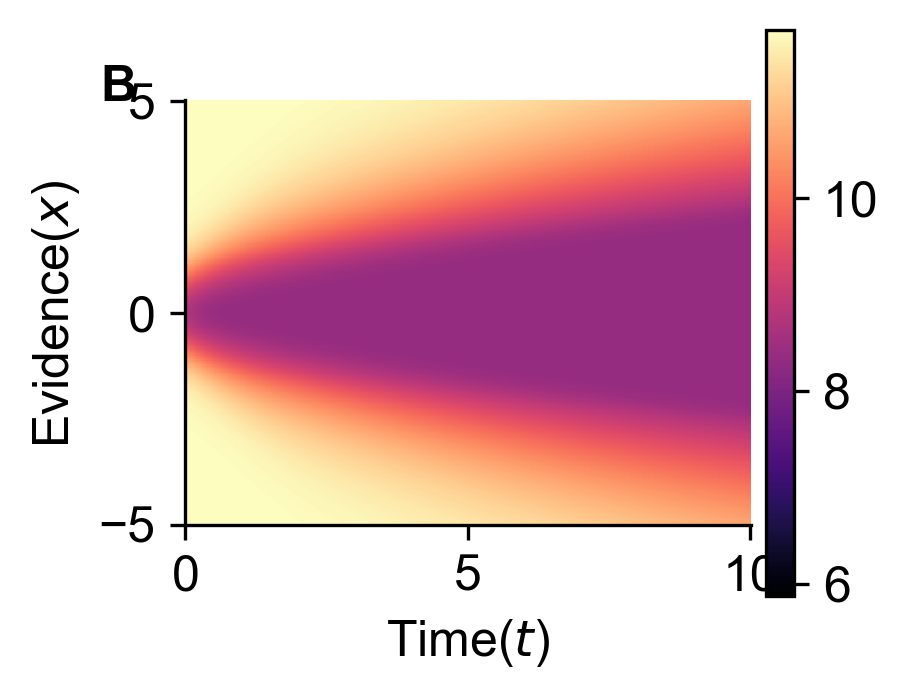

In [17]:
def noinfmin(V):
    V=aa(V)
    V[V==-np.inf]=np.nan
    return np.nanmin(V)
def Vcf_kwargs(vmin,vmax):
    return {'vmin':vmin,'vmax':vmax,'cmap':mpl.cm.magma,'rasterized':True}
Vaxes_kwargs={'xlabel':'Time($t$)','ylabel':'Evidence($x$)','aspect':0.75}
titles=['Value Function','Probability of Choosing Left','Expected Value Function']


from mpl_toolkits.axes_grid1 import make_axes_locatable
block=[V,Rh_left,EVnext]
block_std=[V_std,Rh_left_std,EVnext_std]


with ppp.SF('V_UR',figs_folder,mk) as (fig,axes):
    syn_block=np.c_[V,V_std]
    cf=axes.pcolormesh(*xxyy,V,**Vcf_kwargs(noinfmin(syn_block),np.max(syn_block)))
    axes.set(**Vaxes_kwargs)

    divider = make_axes_locatable(axes)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cf,cax=cax)



## Figure 4D

figure used in paper is stored in paper_figs/fig4/D.svg


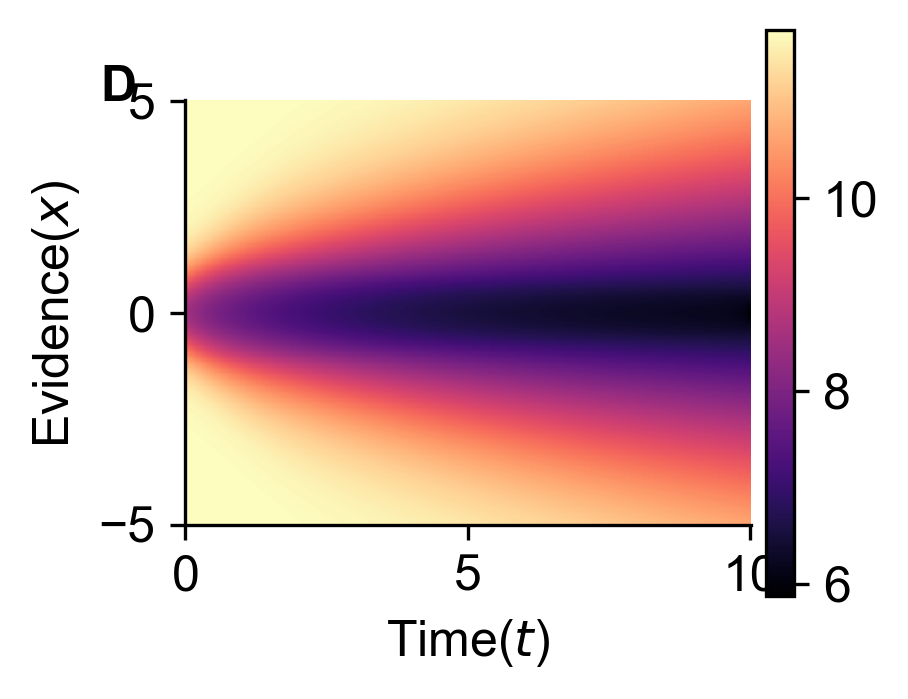

In [18]:

with ppp.SF('V_STD',figs_folder,mk) as (fig,axes):
    syn_block=np.c_[V,V_std]
    cf=axes.pcolormesh(*xxyy,V_std,**Vcf_kwargs(noinfmin(syn_block),np.max(syn_block)))
    axes.set(**Vaxes_kwargs)

    divider = make_axes_locatable(axes)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cf,cax=cax,shrink=0.2)
    